# 0. Import

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
chessboard_folder = 'data/chessboard'
chess_pieces_folder = 'data/chess_pieces'

INPUT_SIZE = 1080

# I. Function to preprocess the image

### I.1 Crop and wrap image

In [20]:
def show_image_rgb(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [13]:
def reorder_points(pts):
    """
    Sort corners into order: 
        [top-left, top-right, bottom-right, bottom-left]
    """
    pts = pts.astype(np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    ordered = np.zeros((4, 2), dtype=np.float32)
    ordered[0] = pts[np.argmin(s)]      # top-left
    ordered[2] = pts[np.argmax(s)]      # bottom-right
    ordered[1] = pts[np.argmin(diff)]   # top-right
    ordered[3] = pts[np.argmax(diff)]   # bottom-left
    return ordered

def detect_corners(img):
    """
    Inspired by Sudoku detection approach:
    1) Grayscale, blur
    2) Adaptive threshold
    3) Morphological closing
    4) Find largest contour that isn't too small or too large
    5) Approximate to 4 corners -> return
    6) Otherwise fallback to rotated bounding box
    """
    # 1) Grayscale + blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    # 2) Adaptive threshold (makes the board region bright/white)
    #    We invert so that the board is white on black background
    thresh = cv2.adaptiveThreshold(
        gray_blur, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11,    # blockSize
        2      # C constant subtracted from mean
    )
    # Invert: the board area becomes white, background black
    thresh = cv2.bitwise_not(thresh)

    # 3) Morphological closing to fill gaps in the board edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 4) Find contours in the closed image
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Sort by descending area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    img_area = img.shape[0] * img.shape[1]

    # Attempt to find a 4-corner polygon
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Filter out tiny or massive (entire image) contours
        if area < 0.02 * img_area or area > 0.9 * img_area:
            continue

        # Approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        
        # If we get 4 corners, reorder and return
        if len(approx) == 4:
            corners = approx.reshape(4, 2)
            return reorder_points(corners)

    # 5) Fallback: if no 4-corner polygon found, 
    #    use minAreaRect on the largest plausible contour
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 0.02 * img_area or area > 0.9 * img_area:
            continue
        rect = cv2.minAreaRect(cnt)   # ((cx,cy),(w,h),angle)
        box = cv2.boxPoints(rect)     # 4 corner points
        return reorder_points(box)

    return None

def warp_perspective(image, corners):
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
    
    image = np.array(image)

    rect = order_points(np.array(corners, dtype="float32"))
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

### I.2 Detect chessboard squares

In [14]:
def detect_straight_lines(edges, threshold=100, min_line_length=50, max_line_gap=10):
    """
    Détecte les lignes droites sur une image de bords (Canny) en utilisant la transformée de Hough.
    :param edges: Image binaire des bords obtenue avec Canny.
    :param threshold: Seuil pour la détection des lignes.
    :param min_line_length: Longueur minimale pour qu'une ligne soit prise en compte.
    :param max_line_gap: Distance max entre deux segments pour être considérés comme une seule ligne.
    :return: Liste des lignes détectées sous forme de tuples (x1, y1, x2, y2).
    """
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    return [] if lines is None else [tuple(line[0]) for line in lines]

In [15]:
def extend_line(x1, y1, x2, y2, img_shape):
    """
    Prolonge une ligne (x1, y1, x2, y2) en respectant son angle, pour qu'elle couvre toute l'image.
    """
    height, width = img_shape[:2]

    # Calcul de l'angle et direction
    if x2 != x1:
        slope = (y2 - y1) / (x2 - x1)  # Pente de la ligne
        y_intercept = y1 - slope * x1  # Ordonnée à l'origine

        # Prolongement vers la gauche (x = 0) et la droite (x = width)
        x_left, y_left = 0, int(y_intercept)
        x_right, y_right = width, int(slope * width + y_intercept)

        # Clamping des valeurs pour rester dans l'image
        if y_left < 0 or y_left > height:
            y_left = max(0, min(y_left, height))
            x_left = int((y_left - y_intercept) / slope)

        if y_right < 0 or y_right > height:
            y_right = max(0, min(y_right, height))
            x_right = int((y_right - y_intercept) / slope)
        
        return (x_left, y_left, x_right, y_right)

    else:  # Cas particulier d'une ligne verticale
        return (x1, 0, x2, height)

def draw_extended_lines(image, lines):
    """
    Dessine les lignes prolongées sur l'image.
    """
    img_with_lines = image.copy()
    for x1, y1, x2, y2 in lines:
        extended_line = extend_line(x1, y1, x2, y2, img_with_lines.shape)
        cv2.line(img_with_lines, (extended_line[0], extended_line[1]), 
                 (extended_line[2], extended_line[3]), (0, 255, 0), 2)

    return img_with_lines

In [16]:
import math

def extended_lines(lines, image):
    extended_lines = []
    for x1, y1, x2, y2 in lines:
        extended_line = extend_line(x1, y1, x2, y2, image.shape)
        extended_lines.append(extended_line)
    return extended_lines

def avg_extended_lines(lines, image, threshold=30):
    extented_lines = extended_lines(lines, image)
    merged_lines = []
    merged = set()  # Utilisation d'un ensemble pour éviter les doublons et optimiser les recherches

    for x1, y1, x2, y2 in extented_lines:
        if (x1, y1, x2, y2) not in merged:
            to_merge = [(x1, y1, x2, y2)]
            for x3, y3, x4, y4 in extented_lines:
                if (x3, y3, x4, y4) not in merged and (x3, y3, x4, y4) not in to_merge:
                    if math.dist((x1, y1), (x3, y3)) < threshold and math.dist((x2, y2), (x4, y4)) < threshold:
                        to_merge.append((x3, y3, x4, y4))

            # Moyenne des points des lignes fusionnées
            avg_x1 = sum(x[0] for x in to_merge) // len(to_merge)
            avg_y1 = sum(x[1] for x in to_merge) // len(to_merge)
            avg_x2 = sum(x[2] for x in to_merge) // len(to_merge)
            avg_y2 = sum(x[3] for x in to_merge) // len(to_merge)

            # Ajout des lignes fusionnées à l'ensemble des lignes traitées
            merged.update(to_merge)
            merged_lines.append((avg_x1, avg_y1, avg_x2, avg_y2))
        
    return merged_lines

In [17]:
def classify_lines(lines, img_width, margin=0.1):
    """
    Classe les lignes en quasi-horizontales ou quasi-verticales 
    en fonction de la position de leurs extrémités dans l'image.

    Paramètres :
        - lines : liste des lignes [(x1, y1, x2, y2)]
        - img_width : largeur de l'image (pour évaluer les limites gauche/droite)
        - margin : pourcentage de la largeur de l'image utilisé comme seuil (ex: 10%)

    Retour :
        - horizontal : liste des lignes horizontales
        - vertical : liste des lignes verticales
    """
    horizontal = []
    vertical = []

    left_limit = img_width * margin  # Seuil gauche
    right_limit = img_width * (1 - margin)  # Seuil droit

    for x1, y1, x2, y2 in lines:
        if (min(x1, x2) < left_limit) and (max(x1, x2) > right_limit):  
            horizontal.append((x1, y1, x2, y2))  # Lignes horizontales
        else:
            vertical.append((x1, y1, x2, y2))  # Lignes verticales

    return horizontal, vertical

def find_intersections(lines1, lines2):
    """Trouve les points d'intersection entre deux groupes de lignes en résolvant les équations des droites."""
    pts_on_vertical_lines = {}
    pts_on_horizontal_lines = {}
    intersections = []
    for (x1, y1, x2, y2) in lines1:
        for (x3, y3, x4, y4) in lines2:
            # Calcul des coefficients des droites
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if abs(denom) < 1e-6:  # Lignes parallèles
                continue

            # Calcul des coordonnées d'intersection
            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

            # if 0 <= px <= cropped.shape[1] and 0 <= py <= cropped.shape[0]:  # Vérifie que le point est dans l'image
            intersections.append((int(px), int(py)))

            if (x1, y1, x2, y2) not in pts_on_horizontal_lines:
                pts_on_horizontal_lines[(x1, y1, x2, y2)] = [(int(px),int(py))]
            else:
                pts_on_horizontal_lines[(x1, y1, x2, y2)].append((int(px),int(py)))
            
            if (x3, y3, x4, y4) not in pts_on_vertical_lines:
                pts_on_vertical_lines[(x3, y3, x4, y4)] = [(int(px),int(py))]
            else:
                pts_on_vertical_lines[(x3, y3, x4, y4)].append((int(px),int(py)))

    return intersections, pts_on_horizontal_lines, pts_on_vertical_lines

In [18]:
def most_regular_segment(points, min_length=8, max_length=9, threshold=0.5):
    """
    Trouve la séquence de 8 ou 9 points les plus régulièrement espacés,
    en priorisant une séquence de 9 si elle est acceptable.
    Si une séquence de 8 est choisie, on ajoute un 9ᵉ point à l'opposé du bord le plus proche.

    :param points: Liste de tuples (x, y) représentant les points d'une droite.
    :param min_length: Longueur minimale du segment (8 par défaut).
    :param max_length: Longueur maximale du segment (9 par défaut).
    :param threshold: Seuil d'écart-type maximal pour considérer une séquence de 9 comme acceptable.
    :return: Liste de 9 points les plus régulièrement espacés.
    """
    n = len(points)
    if n < min_length:
        return points  # Pas assez de points pour former un segment valide

    best_segment_9 = None
    best_segment_8 = None
    min_variation_9 = float('inf')
    min_variation_8 = float('inf')
    best_start_8 = None  # Indice du début du segment de 8

    # Essayer toutes les sous-séquences de taille 8 et 9
    for start in range(n):
        for length in [9, 8]:  # Priorité à 9
            end = start + length
            if end > n:
                continue
            
            segment = points[start:end]

            # Calcul des distances successives entre les points
            distances = [np.linalg.norm(np.array(segment[j+1]) - np.array(segment[j])) for j in range(len(segment) - 1)]
            
            # Calcul de l'écart-type des distances pour mesurer la régularité
            variation = np.std(distances)

            # Vérifier si c'est une séquence de 9 acceptable
            if length == 9 and variation < min_variation_9:
                min_variation_9 = variation
                best_segment_9 = segment

            # Vérifier si c'est une séquence de 8 meilleure
            if length == 8 and variation < min_variation_8:
                min_variation_8 = variation
                best_segment_8 = segment
                best_start_8 = start

    # Si la séquence de 9 est suffisamment régulière, la retourner
    if best_segment_9 and min_variation_9 <= threshold:
        return best_segment_9

    # Sinon, retourner la meilleure séquence de 8 et ajouter un point à l'opposé du bord le plus proche
    if best_segment_8:
        start = best_start_8
        end = start + 8

        # Déterminer les candidats à ajouter (point avant ou après la séquence)
        left_point = points[start - 1] if start > 0 else None
        right_point = points[end] if end < n else None

        # Trouver le bord le plus proche
        if left_point and right_point:
            left_dist = np.linalg.norm(np.array(left_point) - np.array(best_segment_8[0]))
            right_dist = np.linalg.norm(np.array(right_point) - np.array(best_segment_8[-1]))

            if left_dist < right_dist:
                best_segment_8.append(right_point)  # Ajouter à droite (opposé de gauche)
            else:
                best_segment_8.insert(0, left_point)  # Ajouter à gauche (opposé de droite)
        elif left_point:
            best_segment_8.append(left_point)  # Ajouter à droite si possible
        elif right_point:
            best_segment_8.insert(0, right_point)  # Ajouter à gauche si possible

        return best_segment_8

    return None 

def points_to_keep(pts_on_horizontal_lines, pts_on_vertical_lines):
    horizontal_points_to_keep = []
    for line in pts_on_horizontal_lines:
        sorted_points = sorted(pts_on_horizontal_lines[line], key=lambda x: x[0])
        regular_points = most_regular_segment(sorted_points)
        for point in regular_points:
            if point not in horizontal_points_to_keep:
                horizontal_points_to_keep.append(point)
    
    vertical_points_to_keep = []
    for line in pts_on_vertical_lines:
        sorted_points = sorted(pts_on_vertical_lines[line], key=lambda x: x[1])
        regular_points = most_regular_segment(sorted_points)
        for point in regular_points:
            if point not in vertical_points_to_keep:
                vertical_points_to_keep.append(point)
    
    points_to_keep = [point for point in horizontal_points_to_keep if point in vertical_points_to_keep]
    return points_to_keep

# II. Detection pipeline

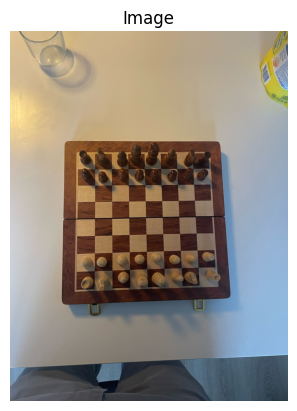

In [54]:
image_path = "data\chessboard\chessboard_7.jpg"
image = cv2.imread(image_path)
show_image_rgb(image, title="Image")

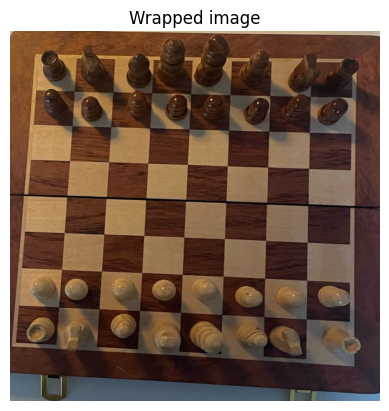

In [55]:
corners = detect_corners(image)
wrapped = warp_perspective(image, corners)
cropped = cv2.resize(wrapped, (INPUT_SIZE, INPUT_SIZE), interpolation=cv2.INTER_AREA)
show_image_rgb(cropped, title="Wrapped image")

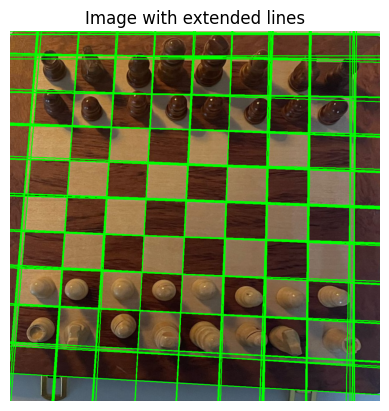

In [56]:
cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
cropped_blur = cv2.GaussianBlur(cropped_gray, (7, 7), 2)
edges = cv2.Canny(cropped_blur, 50, 150)
lines = detect_straight_lines(edges)

image_with_extended_lines = draw_extended_lines(cropped, lines)
show_image_rgb(image_with_extended_lines, "Image with extended lines")

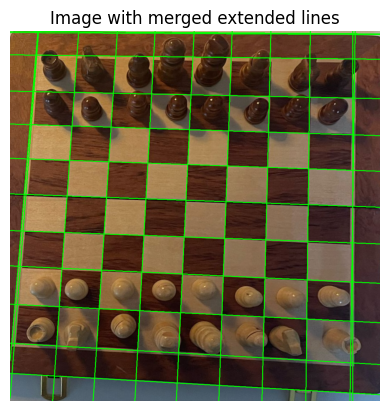

In [57]:
grouped_lines = avg_extended_lines(lines, cropped, threshold=50)
image_with_merged_extended_lines = draw_extended_lines(cropped, grouped_lines)
show_image_rgb(image_with_merged_extended_lines, "Image with merged extended lines")

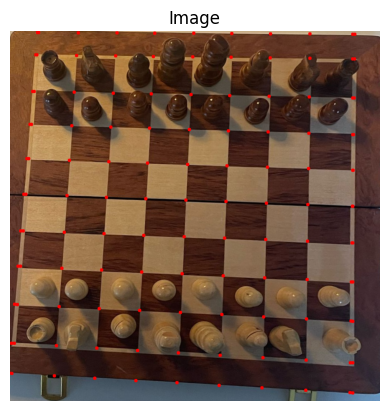

In [58]:
horizontal_lines, vertical_lines = classify_lines(grouped_lines, cropped.shape[0])
intersections, pts_on_horizontal_lines, pts_on_vertical_lines = find_intersections(horizontal_lines, vertical_lines)

cropped_with_init_grid_points = cropped.copy()
for (px, py) in intersections:
    cv2.circle(cropped_with_init_grid_points, (px, py), 5, (0, 0, 255), -1)
show_image_rgb(cropped_with_init_grid_points)

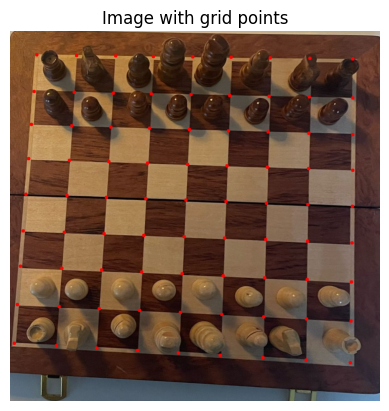

In [61]:
grid_points = points_to_keep(pts_on_horizontal_lines, pts_on_vertical_lines)

cropped_with_grid_points= cropped.copy()
for (px, py) in grid_points:
        cv2.circle(cropped_with_grid_points, (px, py), 5, (0, 0, 255), -1)
show_image_rgb(cropped_with_grid_points, "Image with grid points")